<a href="https://colab.research.google.com/github/lijin-durairaj-code-mode/lang-chain-projects/blob/main/email_classification_langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install langgraph langchain langchain_openai colorama langchain_groq
# !pip install langchain_community
# !pip install langchain_huggingface

In [2]:
from typing import TypedDict, List

# from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig

from langgraph.graph import StateGraph, END, START
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate
)

from transformers import(
    pipeline
)
from google.colab import userdata
import torch
from huggingface_hub import(
    HfFolder
)
from langchain_huggingface import(
    HuggingFaceEndpoint
)
from langchain.chains import (
    LLMChain
)

## variables

In [3]:
HfFolder.save_token(userdata.get('hf_token'))
_device='cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
!huggingface-cli whoami

LijinDurairaj


## models

In [4]:
sentiment_llm=pipeline(
    'text-classification',
    model='distilbert/distilbert-base-uncased-finetuned-sst-2-english'
)


llm_for_message = HuggingFaceEndpoint(
    repo_id='mistralai/Mixtral-8x7B-Instruct-v0.1', max_length=2000, temperature=0.5,
    token=userdata.get('hf_token')
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
                    max_length was transferred to model_kwargs.
                    Please make sure that max_length is what you intended.
                    token was transferred to model_kwargs.
                    Please make sure that token is what you intended.


## prompt

In [5]:
negative_shot_prompt='''
Example 1:
User: I am not able to work in this hostile environment
Assistant: we apologize for the inconvenience caused,
we will try to resolve the issue as soon as possible.

Example 2:
User: I am not able to start my laptop, I have raised the issue several days
ago but it is still not resolved.
Assistant:sorry for the trouble caused, we will try to solve the
issue as soon as possible

Example 3:
User:I have been trying to contact you many times but i have not received any response
Assistant: sorry to hear that, we will arrange a call back soon.

Now, Continue:
'''

positive_shot_prompt='''
Example 1:
User: Thank you for offering me with JOB, I am very happy.
Assistant: great! we are glad to hear that

Example 2:
User: Thanks for giving me great discount in shopping.
Assistant: We are glad to serve you, please visit our store next time.

Example 3:
User: Food was awesome
Assistant: Thank you for the compliment

Now, Continue:
'''

system_message_prompt_negative=SystemMessagePromptTemplate.from_template(
    template='''
  you are an excellent Customer Support Executive, Please provide
 a response to the users email \n\n {negative_shot_prompt}
 '''
)
system_message_prompt_positive=SystemMessagePromptTemplate.from_template(
    template='''
  you are sarcastic Customer Support Executive, Please provide
 a response to the users email \n\n {positive_shot_prompt}
 '''
)

users_email_content=HumanMessagePromptTemplate.from_template(
   '''{email_content}'''
)

chat_prompt_negative=ChatPromptTemplate.from_messages([
  system_message_prompt_negative, users_email_content
])
chat_prompt_positive=ChatPromptTemplate.from_messages([
  system_message_prompt_positive, users_email_content
])

## actual code

In [17]:
class AgentState(TypedDict):
  email_content:str
  predicted_sentiment:str
  reply_content:str

workflow=StateGraph(AgentState)

def find_out_emotion(state:AgentState):
  prediction=llm.predict(state['email_content'])
  state['predicted_sentiment']=prediction[0]['label']
  return state

def negative_func_call(state:AgentState):
  llm=LLMChain(
      llm=llm_for_message,
      prompt=chat_prompt_negative
  )
  messages=llm.invoke({
     'negative_shot_prompt': negative_shot_prompt,
     'email_content':state['email_content']
  })
  state['reply_content']=messages['text']
  return state

def positive_func_call(state:AgentState):
  llm=LLMChain(
      llm=llm_for_message,
      prompt=chat_prompt_positive
  )
  messages=llm.invoke({
     'negative_shot_prompt': positive_shot_prompt,
     'email_content':state['email_content']
  })
  state['reply_content']=messages['text']
  return state

def print_content(state:AgentState):
  print(state['reply_content'])
  print('--- email send ---')
  return state

# @@@---conditional function
def decide_template(state:AgentState):
  if state['predicted_sentiment']=='NEGATIVE':
    return 'negative_template'
  else:
    return 'positive_template'

# intializing nodes
workflow.add_node('find_out_emotion',find_out_emotion)
workflow.add_node('negative_template',negative_func_call)
workflow.add_node('positive_template',positive_func_call)
workflow.add_node('print_content',print_content)

# pinning nodes
workflow.set_entry_point('find_out_emotion')
workflow.add_conditional_edges(
    'find_out_emotion',
    decide_template,
    {
        'negative_template':'negative_template',
        'positive_template':'positive_template'
    }
)
workflow.add_edge('negative_template','print_content')
workflow.add_edge('positive_template','print_content')
workflow.add_edge('print_content',END)

app=workflow.compile()

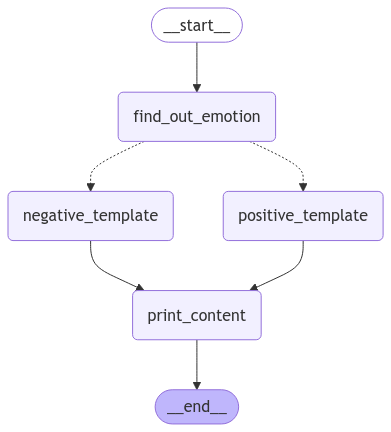

In [18]:
from IPython.display import Image, display

Image(app.get_graph().draw_mermaid_png())

In [19]:
message=app.invoke({
    'email_content':'thanks for offering me the JOB'
})

AttributeError: 'str' object has no attribute 'copy'

# questions
### 1. check why we are not able to use {meta-llama/Llama-3.2-1B} model using pipeline